In [1]:
# Feature Engineering and NLP dataset preparation
# some visualizations on the embeddings

# Example Exercise MBDPT Instacart
# The Instacart Online Grocery Shopping Dataset 2017
# Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 15 January 2024
# Read : https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import itertools

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from tqdm import tqdm, tqdm_notebook
from sklearn.decomposition import PCA

#import sqlalchemy
#from sqlalchemy.types import Integer, Text, String, DateTime, Float
#from sqlalchemy.dialects import postgresql

# import ast


In [3]:
# A couple of functions to use later
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.index_to_key), sample)
#            words = np.random.choice(list(model.vocab.keys()), sample)

        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(16,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [4]:
#Importing INSTACART datasets
# Downloaded froom https://www.kaggle.com/c/instacart-market-basket-analysis
# Metadata in https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

orders = pd.read_csv("./data/orders.csv")
products = pd.read_csv("./data/products.csv")
aisles = pd.read_csv("./data/aisles.csv")
departments = pd.read_csv("./data/departments.csv")
# order_products_ corresponds to the baskets. It is divided in 3 sets, prior (orders in the past) train (last order)
# and test (for the Kaggle submission) we will not use test for this exercise
order_products_prior = pd.read_csv("./data/order_products__prior.csv")
order_products_train = pd.read_csv("./data/order_products__train.csv")

# recover orders_detailed from previous Notebook

orders_detailed = pd.read_csv('./data/orders_detail.csv')

In [5]:
# objective : vectorize the database at user level.
# to do so we need to vectorize at order level
# Add some features to the order to improve accuracy of the recommendation

**This first part will be heavily based on the notebooks 2.1_w2vec_products_instacart.ipynb and 2.2_w2vec_baskets_instacart.ipynb, which have been developed by professor Gonzalo Casajus**

We will start by applying the code contained in **2.1_w2vec_products_instacart.ipynb**, which will allow us to create a dataframe with the products and their corresponding embeddings.

Basically, the **overall objective of this code is to process and transform product names to create word vectors using a pre-trained Word2Vec model**. For doing so it will be necessary to perform the following **steps**:

1. Prepare language data, making everything lowercase, dropping special characters and tokenizing the text
2. Then we will bring information from our departments and aisles datasets to enrich our products dataframe, concatenizing the existing tokenized product names with the department and aisle names
3. We will train a Word2Vec model with the new dataframe, which will allow us to get the embeddings of the departments and aisles
4. We will create a dictionary and store the word vectors that we have trained, then we will calculate for each row the average vector for the combined column of words (product name + department + aisle) 


In [6]:
# Data Cleansing / Data preparation

# Make everything lowercase.
products['Products_tok'] = products['product_name'].str.lower()

# Clean special characters.
products['Products_tok'] = products['Products_tok'].str.replace('\W', ' ')

# Split products into terms: Tokenize.
products['Products_tok'] = products['Products_tok'].str.split()
products.shape

(49688, 5)

In [7]:
# Merge the products, departments, and aisles dataframes
enriched_prods = pd.merge(products, departments, left_on='department_id', right_on='department_id')
enriched_prods = pd.merge(enriched_prods, aisles, on='aisle_id')

# Add the department and aisle names to the Products_mod column
enriched_prods['Products_mod'] = [prod_tokens + [dept, aisle] for prod_tokens, dept, aisle in zip(enriched_prods['Products_tok'], enriched_prods['department'], enriched_prods['aisle'])]

# Select the columns of interest and display the first row
product_table = enriched_prods[['product_id', 'product_name', 'department', 'aisle', 'department_id', 'aisle_id', 
                                'Products_tok']]
product_table.head(1)

,product_id,product_name,department,aisle,department_id,aisle_id,Products_tok
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,19,61,"[chocolate, sandwich, cookies]"


In [8]:
# Train the Word2Vec model on the product tokens, we create embeddings of 20 positions
w2vec_model = Word2Vec(list(product_table['Products_tok']), vector_size=20, window=10, min_count=1, workers=4)

# Create a dictionary of word vectors for the model
prod_word = {w: w2vec_model.wv[w] for w in w2vec_model.wv.index_to_key}

# Calculate the average vector for each product in a product name (the product name is a composed name of several words like
# chocolate cookies
prods_w2v = {}
for _, row in tqdm(product_table.iterrows()):
    word_vector = [prod_word[word] for word in row['Products_tok'] if word in prod_word]
    if word_vector:
        prods_w2v[row['product_name']] = np.average(word_vector, axis=0)
        
product_table['vectors'] = prods_w2v.values()

49688it [00:06, 8031.54it/s]


In [9]:
product_table.head(1)

,product_id,product_name,department,aisle,department_id,aisle_id,Products_tok,vectors
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,19,61,"[chocolate, sandwich, cookies]","[-2.4250252, 1.580197, -2.2713137, 0.72362995,..."


In [10]:
# Let's visualize the products (we'll use Aisle_id 61 as an example)
# Let's see some products in Aisle 61
df_example = product_table[product_table['aisle_id']==61]



In [11]:
w2vec_model.wv.most_similar('cookies')

[('cookie', 0.9735519886016846),
 ('fudge', 0.9543243646621704),
 ('frosting', 0.9459792375564575),
 ('creme', 0.9439007043838501),
 ('dessert', 0.9413339495658875),
 ('cashew', 0.9354095458984375),
 ('gmo', 0.9323448538780212),
 ('covered', 0.9312049150466919),
 ('pecan', 0.9288852214813232),
 ('brittle', 0.9280589818954468)]

In [12]:
sample = product_table[product_table['product_name']=='Danish Butter Cookies']['vectors'].tolist()
w2vec_model.wv.most_similar(sample)
#w2vec_model.wv.most.similar()

[('whipped', 0.931161642074585),
 ('caramel', 0.9220789670944214),
 ('butter', 0.9155283570289612),
 ('crunchy', 0.9125382304191589),
 ('cashewmilk', 0.9095054864883423),
 ('frosting', 0.905928909778595),
 ('covered', 0.90265291929245),
 ('dessert', 0.9023706316947937),
 ('churned', 0.9019122123718262),
 ('fudge', 0.8985185623168945)]

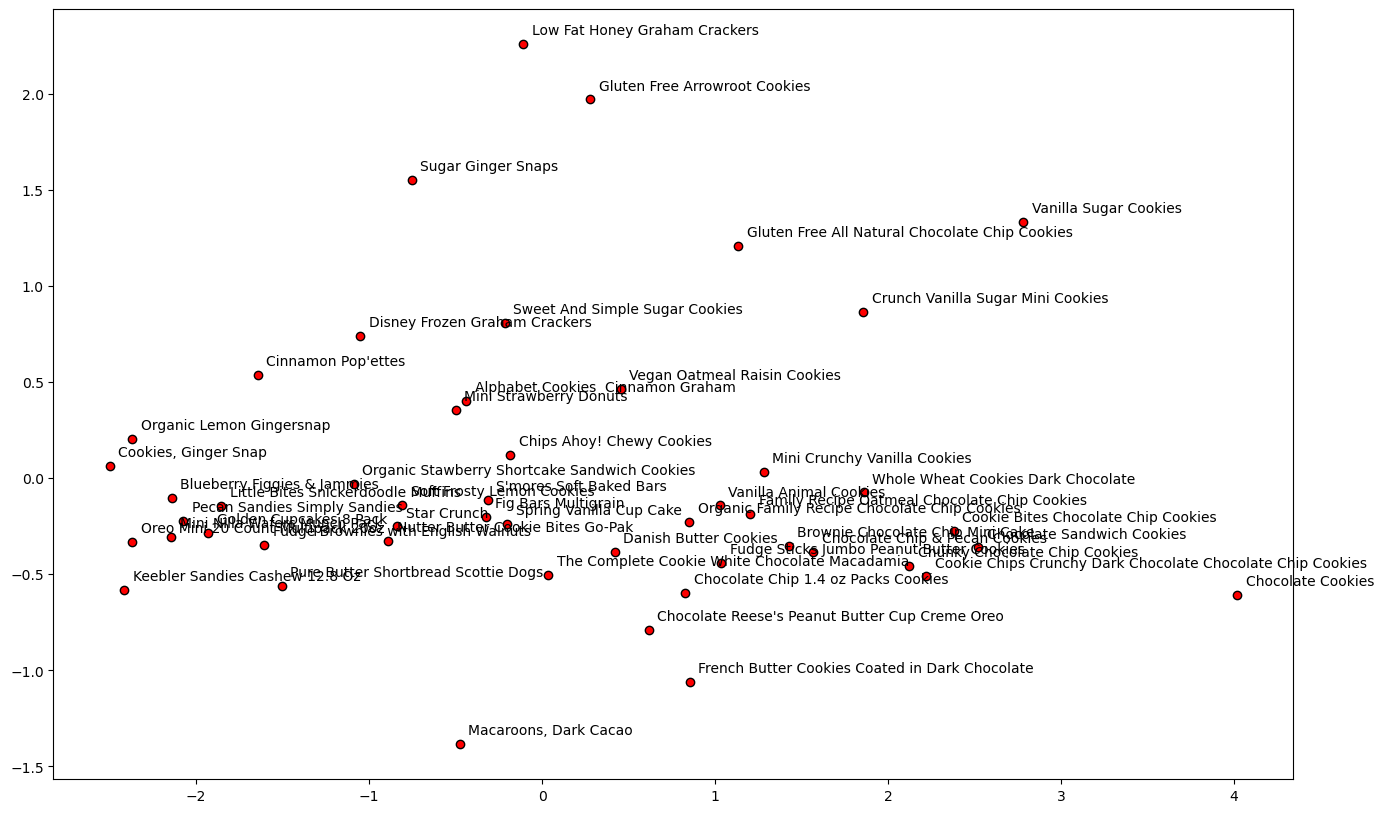

In [13]:
# Let's visualize a PCA of 50 products in aisle 61

aisle_vec = product_table[product_table['aisle_id']==61]['vectors'].values
names = product_table[product_table['aisle_id']==61]['product_name'].values

# for the sake of clarity we only draw the first 50 names

aisle_vec = aisle_vec[:50]
names = names[:50]

twodim = PCA().fit_transform(aisle_vec.tolist())[:,:2]
plt.figure(figsize=(16,10))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(names, twodim):
    plt.text(x+0.05, y+0.05, word)

In [16]:
# Let's see the number of items on each aisle
grouped = product_table.groupby('aisle_id').size().reset_index(name='counts')
grouped['aisle_name'] = aisles['aisle']
print(grouped.to_string()) # trick to print the whole dataset use it only with small ones. problems with large ones

     aisle_id  counts                     aisle_name
0           1     146          prepared soups salads
1           2     271              specialty cheeses
2           3     832            energy granola bars
3           4     543                  instant foods
4           5     409     marinades meat preparation
5           6     548                          other
6           7     100                  packaged meat
7           8     297                bakery desserts
8           9     399                    pasta sauce
9          10     218               kitchen supplies
10         11     427               cold flu allergy
11         12     123                    fresh pasta
12         13     317                 prepared meals
13         14     159         tofu meat alternatives
14         15      80               packaged seafood
15         16      86                    fresh herbs
16         17     623             baking ingredients
17         18      12   bulk dried fruits vege

In [17]:
# Let's see if PCA clusters two aisles
# We create a v vector ith the  vectors from the two aisles

a1, a2 = 75,45

names0, names1, names = [], [], []
aisle_vec0, aisle_vec1, aisle_vec = [], [], []
aisle0, aisle1, aisle = [], [], []


aisle_vec0 = product_table[product_table['aisle_id']==a1]['vectors'].values
names0 = product_table[product_table['aisle_id']==a1]['aisle'].values
aisle0 = product_table[product_table['aisle_id']==a1]['aisle_id'].values

aisle_vec1 = product_table[product_table['aisle_id']==a2]['vectors'].values
names1 = product_table[product_table['aisle_id']==a2]['aisle'].values
aisle1 = product_table[product_table['aisle_id']==a2]['aisle_id'].values

# we use 2000 examples
n = 10000
print(aisle_vec1.shape)
aisle_vec0 = aisle_vec0[:n]
names0 = names0[:n]
aisle0 = aisle0[:n]

aisle_vec1 = aisle_vec1[:n]
names1 = names1[:n]
aisle1 = aisle1[:n]

# we concatenate and create a single array
aisle_vec = np.concatenate((aisle_vec0, aisle_vec1), axis=0)
names = np.concatenate((names0, names1), axis=0)
aisle = np.concatenate((aisle0, aisle1), axis=0)

(1246,)


In [ ]:
# Now we create a nice PCA visualization

X_pca = PCA(n_components=2).fit_transform(aisle_vec.tolist())
colors = ['red','green']
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'] )
pca_df['name'] = names
pca_df['aisle'] = aisle

target_aisles = np.array([a1, a2])

for color, i, aisles_n in zip(colors, [a1,a2], target_aisles):
    plt.scatter(pca_df.loc[pca_df['aisle'] == aisles_n, 'PC1'], pca_df.loc[pca_df['aisle']== aisles_n, 'PC2'],
                       color=color, alpha=.8, s=5, label=target_aisles)

a1_str = aisles.loc[aisles['aisle_id'] == a1,'aisle' ].iloc[0]
a2_str = aisles.loc[aisles['aisle_id'] == a2,'aisle' ].iloc[0]

plt.xlabel('PCA1')
plt.ylabel('PCA2')
    
plt.title('PCA in aisles '+a1_str+' & '+ a2_str)
    
plt.show()

Now, we will go to the nb **2.2_w2vec_baskets_instacart.ipynb**, which will allow us to create a dataframe with the baskets and their corresponding embeddings.

In [ ]:
# We create the embeddings for the baskets
# Merge product vectors with order and product data
# Careful is a long step
# we average (mean) the basket values on each basket

baskets = pd.merge(product_table[['product_id', 'product_name', 'vectors']], order_products_prior[['order_id', 'product_id']])
baskets.head(1)

# Compute basket vectors creating a dataframe (basket_vector) with the averaged value of all the product vectors

basket_vectors = dict()
for order_id, group in tqdm(baskets.groupby('order_id')):
    basket_vector = [product_table.loc[product_table['product_id'] == p, 'vectors'].iloc[0] for p in group['product_id']]
    basket_vectors[order_id] = np.mean(basket_vector, axis=0)

# Display the first 5 basket vectors
for order_id, vector in list(basket_vectors.items())[:5]:
    print(f"Order ID {order_id}: {vector}")

 67%|█████████████████████████████████████████████████▉                        | 2168203/3214874 [2:11:37<1:05:10, 267.63it/s]

In [ ]:
# Create a DataFrame with order ID, vector, and product names and IDs
basket_lists = baskets.groupby('order_id')['product_name'].apply(list)
basket_lists_id = baskets.groupby('order_id')['product_id'].apply(list)

order_vectors = []
for order_id, vector in basket_vectors.items():
    product_names = basket_lists[order_id]
    product_ids = basket_lists_id[order_id]
    order_vectors.append([order_id, vector, product_names, product_ids])

order_vectors_df = pd.DataFrame(order_vectors, columns=['order_id', 'vector', 'product_names', 'product_ids'])

# Display the first 5 rows of the DataFrame
order_vectors_df.head()

In [ ]:
order_vectors_df.info()

In [ ]:
#check unique order_id
order_vectors_df['order_id'].nunique()

Running the previous snippet has been quite a challenge, due to memory constraints. Though, as we have seen, we have been able to create a dataframe with the order vectors. Now, let's start with our feature engineering. The master dataset will be order_vectors_df

### 4.2. Feature Engineering

**In the first part, we will focus on adding existing features to our dataset**. Regarding the features that we will add:

- **user_id**: we will add the user id to the dataset, as in the next sections **it would be the central piece of our recommendation engine.**
- **Time variables**: we will add the time variables that we have in the orders dataset, as they will be useful for our model

We don't need to add any aisles or departments features, as we have already added them in the previous step (when vectorizing). Also, and due to the fact that the objective of this thread is not exactly the same than in the Kaggle one (which basically consists on trying to increase accuracy on the test set), as we want to focus on the qualitative analysis of our outputs, **we will train the model in the prior dataset to then, predict the products that will be bought in the next order of each user, which are inside the train dataset**. This will allow us to compare the predicted products with the real ones, and to perform a qualitative analysis of the results.

In [ ]:
#To the order_id present in the order_vectors_df dataframe, we will add the user_id, order_number, order_dow, order_hour_of_day, days_since_prior_order columns from the orders dataframe
order_vectors_df = pd.merge(order_vectors_df, orders[['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']], on='order_id')

In [ ]:
order_vectors_df.head()

In [ ]:
order_vectors_df.info()

In [ ]:
#Replace NaN values in days_since_prior_order column with 0
order_vectors_df['days_since_prior_order'] = order_vectors_df['days_since_prior_order'].fillna(0)

Now, **we will add some new features** to our dataset. Let's start creating them and, afterwards, we will explain the rationale behind them

In [ ]:
#Add a new column to indicate, for each user_id, the average days_since_prior_order, not considering zero values of days_since_prior_order
order_vectors_df['avg_days_since_prior_order'] = order_vectors_df.groupby('user_id')['days_since_prior_order'].transform(lambda x: x[x!=0].mean())


In [ ]:
#Get the basket_size of each order_id
order_vectors_df['basket_size'] = order_vectors_df['product_ids'].apply(lambda x: len(x))

In [ ]:
#Now, we will add a new column with the avg basket size of each user
order_vectors_df['avg_basket_size'] = order_vectors_df.groupby('user_id')['basket_size'].transform(lambda x: x.mean())

In [ ]:
#Now, for each order, we will extract the first product_id and the last product_id
order_vectors_df['first_product_id'] = order_vectors_df['product_ids'].apply(lambda x: x[0])
order_vectors_df['last_product_id'] = order_vectors_df['product_ids'].apply(lambda x: x[-1])

In [ ]:
#Merge order_vectors_df with product_table to get the vectors
order_vectors_df = order_vectors_df.merge(product_table[['product_id', 'vectors']],
                                          left_on='first_product_id',
                                          right_on='product_id',
                                          how='left')
order_vectors_df.rename(columns={'vectors': 'first_product_vectors'}, inplace=True)
order_vectors_df.drop('product_id', axis=1, inplace=True)

order_vectors_df = order_vectors_df.merge(product_table[['product_id', 'vectors']],
                                          left_on='last_product_id',
                                          right_on='product_id',
                                          how='left')
order_vectors_df.rename(columns={'vectors': 'last_product_vectors'}, inplace=True)
order_vectors_df.drop('product_id', axis=1, inplace=True)

Let's stop and check what new columns we have already introduced

In [ ]:
#show all the rows for one user_id
order_vectors_df[order_vectors_df['user_id'] == 22352]

In [ ]:
order_vectors_df.info()


In [ ]:
#Now, let's go to the order_products_prior dataframe and create on it a new column called 'avg_reordered_products' that will indicate, for each order_id, the average number of reordered products
order_products_prior['avg_reordered_products'] = order_products_prior.groupby('order_id')['reordered'].transform(lambda x: x.mean())
#get a dataframe with the order_id and avg_reordered_products columns
order_products_prior_grouped = order_products_prior[['order_id', 'avg_reordered_products']].drop_duplicates()


In [ ]:
#Checking everything is ok
order_products_prior_grouped.info()

In [ ]:
#Based on order_id, we add to the order_vectors_df dataframe the avg_reordered_products column
order_vectors_df = pd.merge(order_vectors_df, order_products_prior_grouped[['order_id', 'avg_reordered_products']], on='order_id')

In [ ]:
#Now, we create a new column called 'avg_reordered_products_user' that will indicate, for each user_id, the average number of reordered products
order_vectors_df['avg_reordered_products_user'] = order_vectors_df.groupby('user_id')['avg_reordered_products'].transform(lambda x: x.mean())

For creating our next and lasts features, we will first do some transformations on the previously created orders_detailed dataframe

In [ ]:
orders_detailed = pd.read_csv('./data/orders_detail.csv')

In [ ]:
#We take again a look at the orders_detailed df, as it has been quite a while without working with it
orders_detailed.head()

In [ ]:
#We add a column called organic product. If product name contains the word 'organic', then we will assign 1 to the column, otherwise 0
orders_detailed['organic_product'] = orders_detailed['product_name'].apply(lambda x: 1 if 'organic' in x.lower() else 0)

In [ ]:
#For each order_id, we will add up the number of organic products
orders_detailed['organic_products'] = orders_detailed.groupby('order_id')['organic_product'].transform(lambda x: x.sum())

In [ ]:
#for order detail, drop all the columns except order_id and organic_products. Then, drop the duplicates
orders_detailed = orders_detailed[['order_id', 'organic_products']].drop_duplicates()

In [ ]:
#Checking everything is ok
orders_detailed.info()

In [ ]:
#Add to order_vectors_df the organic_products column from the orders_detailed dataframe just when the order_id matches and it is present in order_vectors_df
order_vectors_df = pd.merge(order_vectors_df, orders_detailed[['order_id', 'organic_products']], on='order_id', how='left')

In [ ]:
#We will create a column of the average weight of organic products for each order dividing by basket size
order_vectors_df['avg_organic_products'] = order_vectors_df['organic_products'] / order_vectors_df['basket_size']

In [ ]:
#And finally, we will create a column of the average weight of organic products for each user, adding up avg_organic_products for each order and dividing by the number of orders
order_vectors_df['avg_organic_products_user'] = order_vectors_df.groupby('user_id')['avg_organic_products'].transform(lambda x: x.sum() / len(x))

**We have finished our transformations, so let's check that everything is ok**

In [ ]:
order_vectors_df.info()

In [ ]:
order_vectors_df.head()

In [ ]:
#Show all the rows for one user_id
order_vectors_df[order_vectors_df['user_id'] == 22352]

In [ ]:
type(basket_vector)

In [ ]:
#We create a copy of the order_vectors_df dataframe
prepared_df = order_vectors_df.copy()

# We store the dataframe for next notebooks
prepared_df.to_csv('./data/prepared_df.csv')
#prepared_df.to_parquet('prepared_df.parquet', index=False)

At this point, we can end the creation of features. We will now present the features we have created. **Some of the features are created at order level (as first_product_vectors or last_product_vectors) and other are created at user level (as avg_reorder_products_user or avg_organic_product_user). Our recommendation engine will only use aggregate basket vectors based on user_id, to recommend to an user what products can be bought in the next order. All the other features would be used in achieving the 9th point of the assignment, which consists on exploring the output and validate the results qualitatively. Also, all the features have value and allow to do a further customization of the analytics of Instacart, so we plan to use them in future iterations**

-**Average days between orders for each user**: this variable is calculated by simply grouping by user_id and adding the number of days in the days since last order column, then dividing the result by the total number of orders (without considering the first order). With the inclusion of this variable, we intend to know whether the customer in question uses our service frequently, sporadically or residually.

-**Basket size**: we will add a column to each order that basically will represent how many products are included in each order. This variable will give us in a simple manner the size of each order, and will be useful for posterior features creations.

-**Average basket size per user**: this variable is calculated by grouping by user_id and adding all the basket sizes previously calculated and dividing the result by the number of orders the user has placed. This variable will allow us to identify whether the user uses instacart to make large purchases, i.e. as a substitute for traditional shopping, or small purchases, rather as a complementary or on specific occasions. The combination of this variable with that of average days between orders for each user can give us very relevant insights into the typology of the customer.

-**First and last product bought for each order**: first, we add 2 columns, one with the product_id of the first product added to the cart in the order and other one with the last one. Then, we will go to the previously created product_table, which contains the vectors for each of the products (taking into consideration the product name, the department and the aisle). We will create 2 new columns, one with the vectors of the first product and other one with the vectors of the last one. With this columns we want to better understand consumption patterns of each user. Do they usually start their purchase with the same product? Do they usually end it with the same product? Do they usually start with a product from a specific department? Do they usually end it with a product from a specific department? Do they close their order with a whim? Understanding the trigger of the order and then the closing of it can be very useful for the company, as it can help them to better understand the customer and to better target them with their marketing campaigns.

-**Average reordered products**: For creating this feature, we have gone to the order_products_prior df and we have, for each order, add up all the values in the reordered column and then divided the result by the number of products in the order. For each order, we will obtain a number between 0 and 1. This variable allows us to easily identify the percentage of reordered products in a specific order.

-**Average reordered products per user**: based on the previous created feature, we will try to dig deeper on customer behaviour to complete our understanding of it. For doing so, we will group by user_id and add up all the values in the reordered column and then divided the result by the number of products in the order. For each user, we will obtain also a number between 0 and 1 which will provide us with a clear vision on if the client likes to innovate our uses our service to buy the same products over and over again.

-**Organic products of each order** and **Organic Products Weight at the basket**: in the previously developed EDA we have been able to see that all but one of the most 15 sold products where organic products. For that reason, we have tried to unfold more insights related with this category. At first, we have used the orders_detailed df to create a new column that will contain the number of organic products (organic word is present in the product name) in each order. Then, we have bring this column to our order_vectors_df and we have created a new column that will contain the weight of organic products in each order, based on market size.

-**Organic average products per user**: finally, our last feature will consist on the average number of organic products that each user buys. For doing so, we will group by user_id and add up all the values in the avg_organic_products column and then divided the result by the number of orders the user has placed. This variable will allow us to identify which customers are more prone to buy organic products and more worried about their health.

## **5. Modelization**

The recommendation engine we want to build will work as follows: **it will receive as input, from the customer, a user_id. Based on this user_id, it will recommend a total of 15 products that can potentially form part of the customer's basket.**

**To do this, we will group the vectors, product name and product id of each basket, and calculate the user vectors. Subsequently, we will reduce the dimensionality by adding t-SNE coordinates. The output will be saved as df and loaded into the next notebook, which will constitute the user interface. In that screen, the user will be asked for a user_id and will be shown recommendations for that user_id, as well as the order history of that user_id with all the features we have already created. This will make it easier to evaluate whether the recommendations make sense or not.**


In [ ]:
# #Read the parquet file (uncommend if you want to start from here)
#prepared_df = pd.read_parquet('prepared_df.parquet')

In [ ]:
prepared_df.info()

In [ ]:
#We will prepare the data for getting ready or recommendation engine using a spatial distance model
data_for_model = prepared_df[['order_id', 'vector', 'product_names', 'product_ids', 'user_id']]

In [ ]:
data_for_model.info()

In [ ]:
data_for_model.head()

In [ ]:
from tqdm import tqdm

user_vectors = dict()
for user_id, group in tqdm(data_for_model.groupby('user_id')):
    basket_vectors = [basket_vector for basket_vector in group['vector']]
    user_vectors[user_id] = np.mean(basket_vectors, axis=0)

In [ ]:
#display the first 5 user vectors
user_vectors

In [ ]:
#Here we apply the previous used code for getting the basket vectors but, this time, for getting user vectors

basket_lists = data_for_model.groupby('user_id')['product_names'].apply(list)
basket_lists_id = data_for_model.groupby('user_id')['product_ids'].apply(list)

order_vectors = []
for user_id, vector in user_vectors.items():
    product_names = basket_lists[user_id]
    product_ids = basket_lists_id[user_id]
    order_vectors.append([user_id, vector, product_names, product_ids])

user_model_data = pd.DataFrame(order_vectors, columns=['user_id', 'vector', 'product_names', 'product_ids'])

# Add a column with all orders for each user
user_model_data['orders'] = user_model_data['user_id'].map(data_for_model.groupby('user_id')['order_id'].apply(list))

# Display the first 5 rows of the DataFrame
print(user_model_data.head())

We check that the previous code has worked properly

In [ ]:
#get all the rows of prepared_df that have user_id = 22352
prepared_df[prepared_df['user_id'] == 22352]

In [ ]:
#check all the rows of user_model_data that have user_id = 22352
user_model_data[user_model_data['user_id'] == 22352]

We have tried to compute tsne vectors using the whole dataset for all users but it has been impossible and after 5,000 minutes of running without completing we have interrupted the execution. We will get a sample of the 20,000 users with most orders and we will apply the model to them. This will allow us to have a more manageable dataset and to be able to run the model in a reasonable time.

In [ ]:
#We add a new column containing the number of orders for each user
user_model_data['number_of_orders'] = user_model_data['orders'].apply(lambda x: len(x))

#We get a new df with the top 20,000 users with more orders
top_users = user_model_data.sort_values(by='number_of_orders', ascending=False).head(20000)

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE
import numpy as np

# Perform t-SNE on the vector column in top_users
tsne = TSNE(n_components=2, perplexity=30, learning_rate=500, init='pca', random_state=42)
tsne_vectors = tsne.fit_transform(np.stack(top_users['vector'].to_numpy()))

# Add t-SNE coordinates to top_users
top_users['tsne_x'] = tsne_vectors[:, 0] 
top_users['tsne_y'] = tsne_vectors[:, 1]

# Create interactive t-SNE plot using plotly
fig = px.scatter(top_users, x='tsne_x', y='tsne_y', hover_data=['user_id', 'product_names'])
fig.update_traces(marker=dict(size=8, opacity=0.8))
fig.show()

In [ ]:
top_users.info()


In [ ]:
# #store the top_users dataframe in parquet format (uncomment if needed as a checkpoint)
# top_users.to_parquet('top_users.parquet', index=False)

**We have finished our analysis and we have prepared a df with the 20,000 users with most products. Now, please, go to the second notebook, containing part 2, that will display the recommendations**